# Случайные процессы. Прикладной поток.
## Практическое задание 4

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 4"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `4.N.ipynb` и `4.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке никакой код запускаться не будет.


--------------

Для выполнения задания потребуются следующие библиотеки: hmmlearn, librosa. Следующими командами можно их поставить (Ubuntu):

sudo pip3 install hmmlearn

sudo pip3 install librosa


--------------

### 1. Скрытые марковские модели (2 балла)

Реализация методов является полезной, но технически сложной, поэтому мы воспользуемся готовой реализацией `hmmlearn`. Документация http://hmmlearn.readthedocs.io/. Интерфейс данной библиотеки максимально близок к библиотеке `scikit-learn`. 

Все необходимые комментарии по интерфейсу библиотеки `hmmlearn` приведены в коде далее. Следуйте указаниям.

In [1]:
import numpy as np
import sys
from hmmlearn import hmm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Если при использовании библиотеки будут появлятся различные warnings,
# раскомментируйте и выполните следующий код
import warnings
warnings.filterwarnings("ignore")

Зададим некоторую скрытую марковскую модель

In [3]:
# Объявление скрытой марковской модели с двумя скрытыми состояниями, 
# в которой предполагается, каждое состояние может генерировать 
# гауссовский случайный вектор с произвольной матрицей ковариаций.
# Используется метод Витерби.
# Поставьте 'map', чтобы использовать метод forward-backward.
model = hmm.GaussianHMM(n_components=2, covariance_type='full', 
                        algorithm='viterbi')

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.07, 0.93]])

# Параметры условных распределений Y_j при условии X_j - вектора средних и
# матрица ковариаций по количеству состояний. Поскольку в данном случае
# распределения одномерные, ниже записаны два вектора размерности 1
# и две матрицы размерности 1x1
model.means_ = np.array([[0.0], [3.0]])
model.covars_ = np.array([[[1]], [[1]]])

Сгенерируем некоторую последовательность с помощью определенной выше модели.

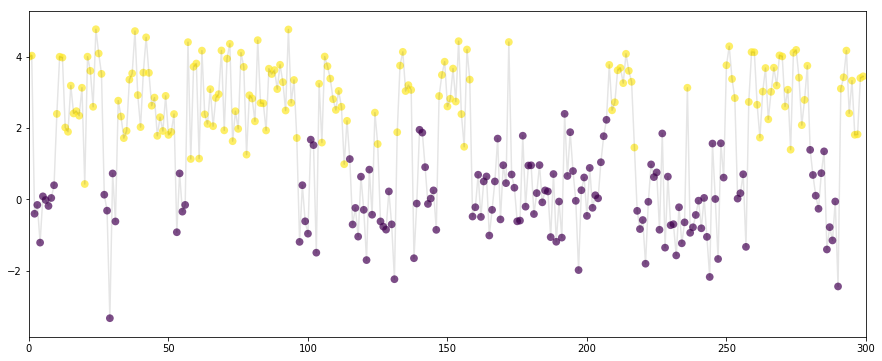

In [4]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()

На основе сгенерированной выше последовательности оценим параметры ("обучим") скрытой марковской модели и значения скрытых состояний.

In [5]:
# Объявление скрытой марковской модели, в которой при оценке параметров 
# будет производиться не более n_iter итераций EM-алгоритма.
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров ("обучение")
remodel.fit(Y)  

# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

Теперь изобразим полученные результаты. На обоих графиках непрозразными маленькими кружочками отмечена исходная последовательность. Полупрозрачными большими кружочками отмечены оценки значений скрытых состояний. На первом графике отмечены все такие точки, на втором только те из них, оценка значения скрытого состояния получилась неправильно.

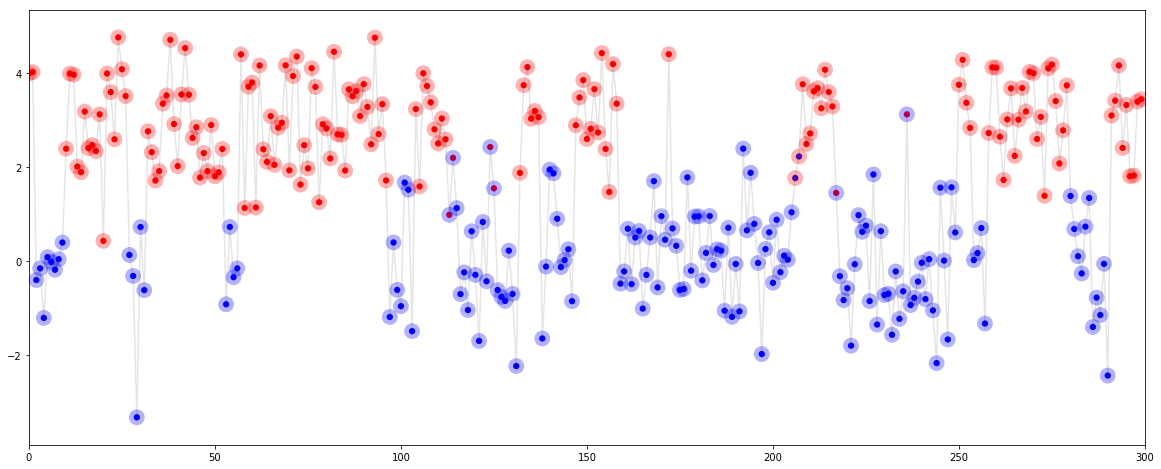

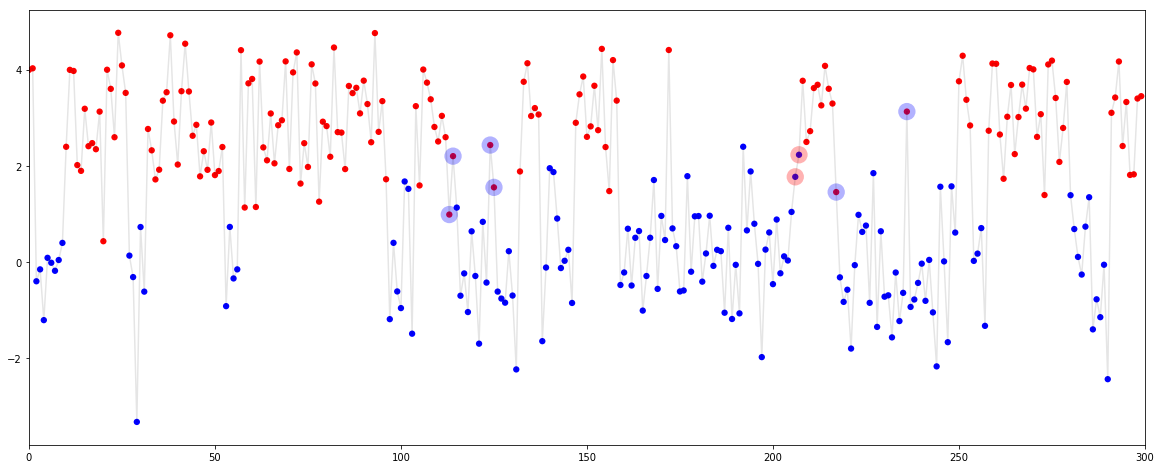

In [6]:
colors = np.array(['blue', 'red'])

# Состояния определяются с точностью до их перестановки.
# При необходимости меняем местами состояния
if (X != X_predicted).sum() > size / 2:
    X_predicted = 1 - X_predicted

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

Как понять, что EM-алгоритм сошелся? Для этого нужно посчитать значение некоторого функционала (см. презентацию), который умеет считать библиотека `hmmlearn`, поэтому мы всего лишь посмотрим на его значения. Данная функциональность в библиотеке реализованна слишком странно. Следуйте комментариям.

In [7]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

Теперь можно загрузить значения и построить график

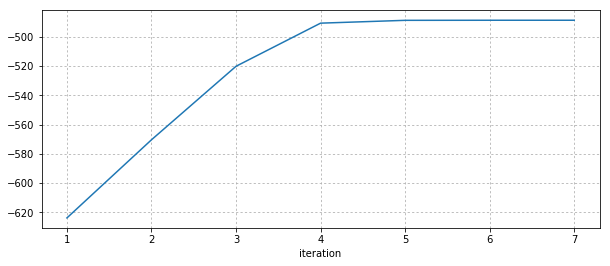

In [8]:
values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.grid(ls=':')
plt.show()

Выполните те же операции для следующих двух случаев

* скрытая марковская цепь имеет три скрытых состояния;

* распределение $Y_j$ при условии $X_j$ является двумерным гауссовским.

In [ ]:
<Код с пояснениями, графики>

<Выводы>

Кроме гауссовского случая в библиотеке реализовано два других

* `hmm.GMMHMM` --- распределение $Y_j$ при условии $X_j$ является смесью гауссовских распределений, 
* `hmm.MultinomialHMM` --- распределение $Y_j$ при условии $X_j$ является дискретным.

In [10]:
# Объявление скрытой марковской модели с тремя скрытыми состояниями, 
# в которой предполагается, каждое состояние может генерировать 
# гауссовский случайный вектор с произвольной матрицей ковариаций.
# Используется метод Витерби.
# Поставьте 'map', чтобы использовать метод forward-backward.
model = hmm.GaussianHMM(n_components=3, covariance_type='full', 
                        algorithm='viterbi')

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей
model.startprob_ = np.array([0.4, 0.4, 0.2])
model.transmat_ = np.array([[0.8, 0.1, 0.1],
                            [0.37, 0.62, 0.01],
                            [0.5, 0.21, 0.29]])

# Параметры условных распределений Y_j при условии X_j - вектора средних и
# матрица ковариаций по количеству состояний. Поскольку в данном случае
# распределения одномерные, ниже записаны два вектора размерности 1
# и две матрицы размерности 1x1
model.means_ = np.array([[0.0], [6.0], [3.0]])
model.covars_ = np.array([[[1]], [[1]], [[1]]])

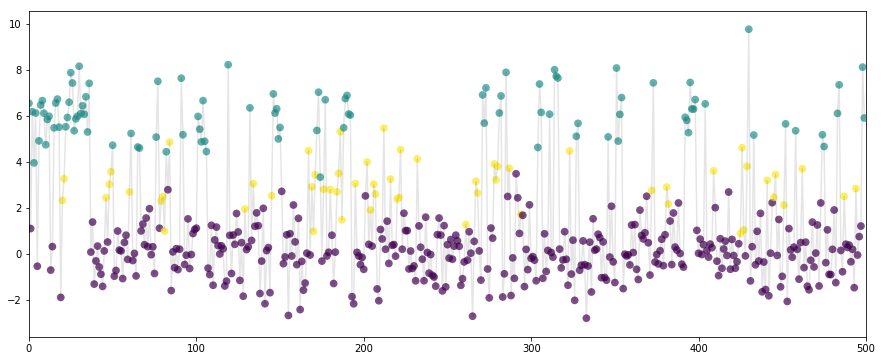

In [11]:
size = 500
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()

In [12]:
# Объявление скрытой марковской модели, в которой при оценке параметров 
# будет производиться не более n_iter итераций EM-алгоритма.
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров ("обучение")
remodel.fit(Y)  

# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

In [13]:
# Могло произойти так, что индексы в X_predicted поменялись местами.
# Тогда их надо поставить в правильном порядке.
# Идея: рассмотрим все перестановки индексов и выберем ту,
# на которой ошибка минимальна.
def correction(X, Y):
    # Полученные сдвигом
    a = Y 
    b = (Y + 1) % 3
    c = (Y + 2) % 3
    
    # Полученные транспозициями
    d = []
    for i in Y:
        if i == 0:
            d.append(1)
        elif i == 1:
            d.append(0)
        else:
            d.append(2)
    d = np.array(d)
    
    e = []
    for i in Y:
        if i == 0:
            e.append(2)
        elif i == 2:
            e.append(0)
        else:
            e.append(1)
    e = np.array(e)
    
    f = []
    for i in Y:
        if i == 1:
            f.append(2)
        elif i == 2:
            f.append(1)
        else:
            f.append(0)
    f = np.array(f)
    
    score_a = (X != a).sum()
    score_b = (X != b).sum()
    score_c = (X != c).sum()
    score_d = (X != d).sum()
    score_e = (X != e).sum()
    score_f = (X != f).sum()
    
    permutations = np.array([a, b, c, d, e, f])
    index = np.argmin([score_a, score_b, score_c, score_d, score_e, score_f])
    
    return permutations[index]

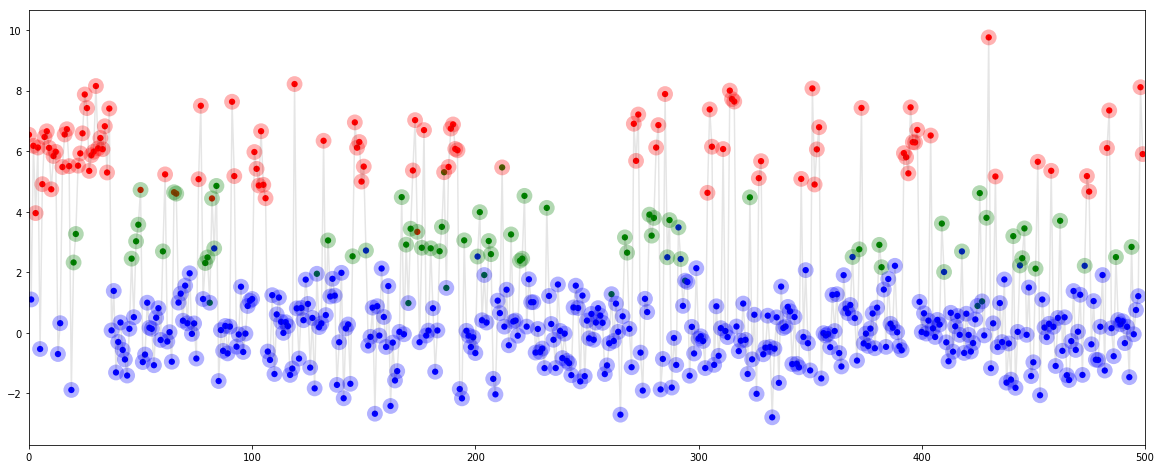

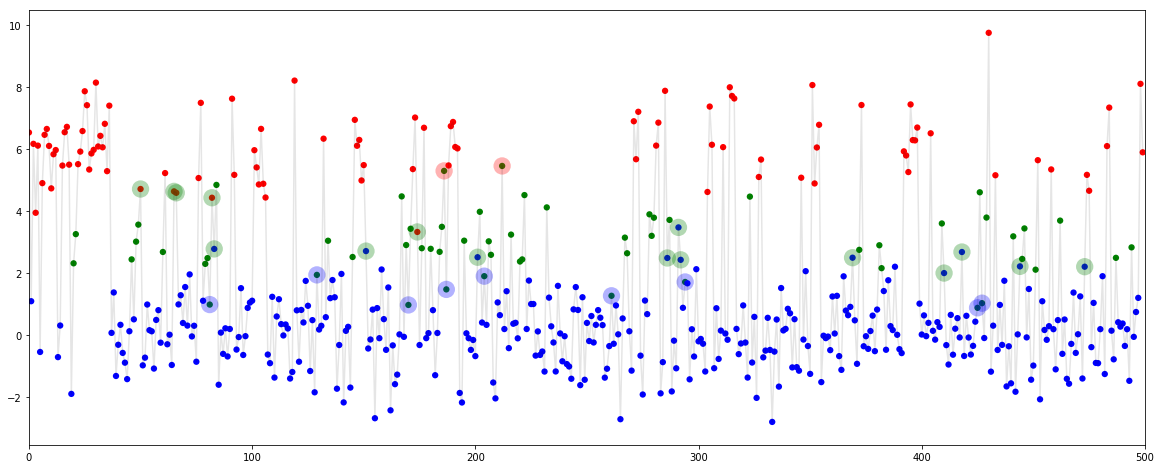

In [14]:
colors = np.array(['blue', 'red', 'green'])

X_predicted = correction(X, X_predicted)

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

In [15]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

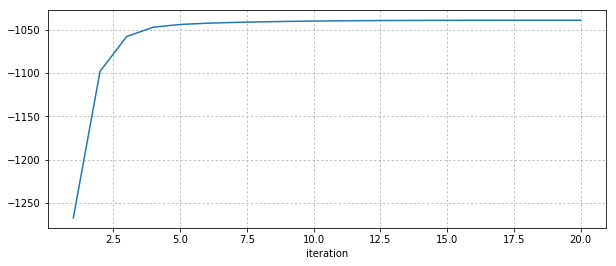

In [16]:
values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.grid(ls=':')
plt.show()

In [ ]:
# Объявление скрытой марковской модели с двумя скрытыми состояниями, 
# в которой предполагается, каждое состояние может генерировать 
# гауссовский случайный вектор с произвольной матрицей ковариаций.
# Используется метод Витерби.
# Поставьте 'map', чтобы использовать метод forward-backward.
model = hmm.GaussianHMM(n_components=3, covariance_type='full', 
                        algorithm='viterbi')

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей
model.startprob_ = np.array([0.4, 0.4, 0.2])
model.transmat_ = np.array([[0.8, 0.1, 0.1],
                            [0.37, 0.62, 0.01],
                            [0.5, 0.21, 0.29]])

# Параметры условных распределений Y_j при условии X_j - вектора средних и
# матрица ковариаций по количеству состояний. Поскольку в данном случае
# распределения одномерные, ниже записаны два вектора размерности 1
# и две матрицы размерности 1x1
model.means_ = np.array([[0.0], [3.0], [2.0]])
model.covars_ = np.array([[[1]], [[1]], [[1]]])

### 2. Part-of-speach tagging (8 баллов)

Теперь вам нужно самостоятельно реализовать метод распознавания частей речи для слов в предложении на основе скрытых марковских моделей. Метод реализовать можно с помощью библиотеки `hmmlearn`, но хранение разреженных матриц в в формате обычных матриц потребует большого количества памяти, поэтому на этот раз реализовать HMM придется самостоятельно. 

Будем считать, что каждый следующий тег непосредственно зависит только от двух предыдущих. Такая модель является марковской цепью, если в качестве состояний рассматривать все возможные пары тегов, причем матрица переходных вероятностей будет разреженной. Чтобы однозначно задать матрицу переходных вероятностей достаточно определить вероятности $\mathsf{P}(X_3=tag_3 \left| X_2=tag_2, X_1=tag_1\right)$, в качестве которых возьмем их оценку максимального правдоподобия (см. семинар). Сделайте так же оценку вероятностей $\mathsf{P}(Y_i=word \left| X_i=tag\right)$ для определения распределения слов для каждого тега.

Для удобства реализации можно считать, что перед началом предложения и после конца предложения находится несколько "пустых" тегов.

После того, как определена модель, нужно реализовать функцию, которая по заданному предложению для данной модели будет находить траекторию Витерби. Эта траектория и будет являться оценкой последовательности тегов для данного предложения. Посчитайте точность определения тегов на тестовом наборе данных.

**Данные** возьмите такие же, как в примере с семинара.

Сравните точность вашей модели с простой моделью, которая была показана на семинаре, а так же со следующими встроенными моделям:

In [ ]:
unigram_tagger = nltk.UnigramTagger(train_sents)
bigram_tagger = nltk.BigramTagger(train_sents)
combined_bigram_tagger = nltk.BigramTagger(train_sents, backoff=unigram_tagger)